# Testing 12 leads ECG classification and model interpretation with SHAP

Using the foillowing dataset : http://2018.icbeb.org/Challenge.html

Which compile 6877 12 leads ECGS from different patients and label them in 9 classes (1 normal, 8 pathological), we are going to train a desktop computeur sizeable classifier.

The porcess is very different yet very inspired by https://www.sciencedirect.com/science/article/pii/S2589004221003412

To make it fit on my single RTX 3080 I had to look at only the last 3 secondes of the ECG, so 1500 points per lead, which is 10 times less than what they did in their paper.

Instead of 4 ResNet blocks I used two GRU with 400 and 200 output dimensions. Before , I used 2 LSTM layers with 200 and 100 output dimension. SInce I was hitting my gpu memory limit with those config I moved to GRU and so was able to train a bigger model which lead to an increase in f1_macro on test set from 0.5 to 0.56. So I believe that with better gear I could increase the model size and get 30 seconds recording in, like in the publication which should increase my f1 macro score.

I first used a weighted cross entropy as loss function, but got rid of the weighted as it was indering the model.

Normalization played a crucial role.

Finally, because I was using the SHAP library for feature inteprretation, that messed up a bit the beauty of the code that you usually can achieve with pytorch lightning... but is is what it is. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [41]:
import os

import numpy as np
import torch

import torch.nn as nn

import torch; torch.manual_seed(0)

import torch.nn.functional as F
import torch.utils
import torch.distributions
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 150

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

from torch.utils import data
from torch.utils.data import DataLoader


import pandas as pd

import scipy as sc
import seaborn as sns

import scipy.io
import sklearn
import seaborn as sns
import json

In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Data exploration

In [4]:
leads=['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

In [5]:
def making_dico_label(file,list_classes):
    df=pd.read_csv(file)
    
    dico_filename_label={n:torch.LongTensor([0 if u!=l-1 else 1 for u in range(9)]) for n,l in zip(df['Recording'],df['First_label'])}
    dico_label={n:l-1 for n,l in zip(df['Recording'],df['First_label'])}
    dico_label_name={i:l for i,l in enumerate(list_classes)}
    
    return dico_filename_label, dico_label_name,dico_label

In [6]:
dico_filename_label, dico_label_name,dico_label=making_dico_label('/home/seb/Documents/Deep_learning/ECG/data/REFERENCE.csv',['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE'])

In [7]:
list_file=[i for i in os.listdir('/home/seb/Documents/Deep_learning/ECG/data/TrainingSet')
           if i.endswith('.mat')]

In [8]:
keep_dim_1=[]
for i in list_file:
    mat=scipy.io.loadmat('/home/seb/Documents/Deep_learning/ECG/data/TrainingSet/'+i)
    keep_dim_1.append(mat['ECG'][0][0][2].shape[1])

All the ECGS are not recorded for the same ampunt of time

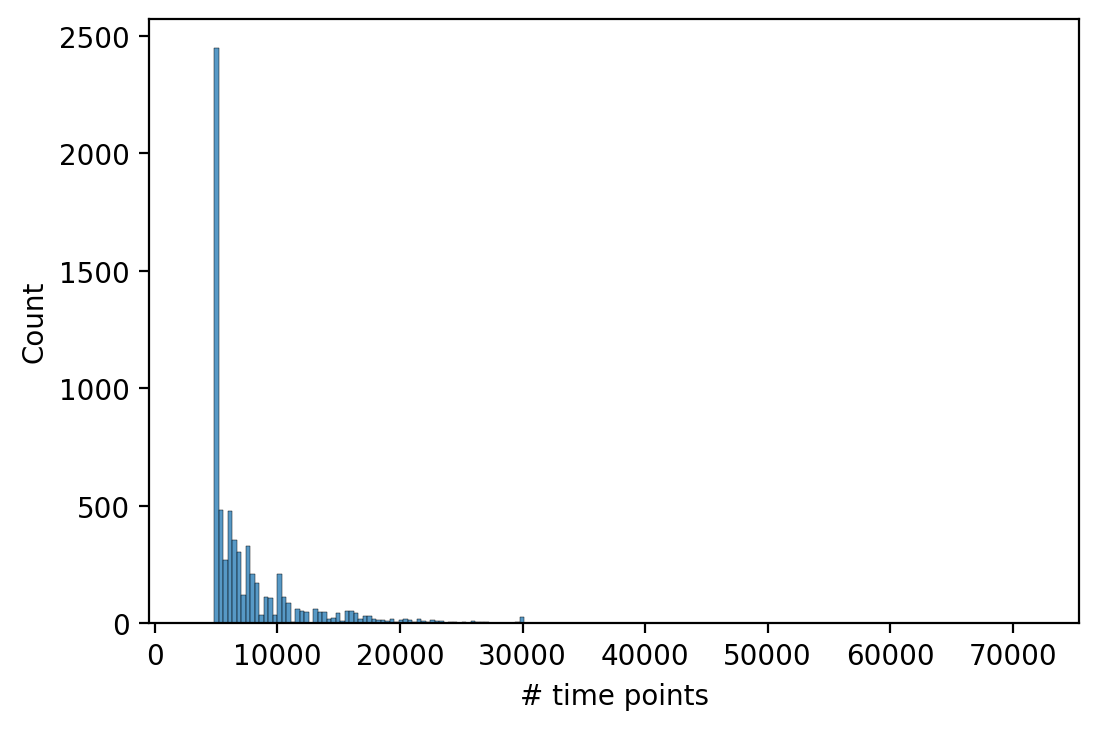

In [9]:
sns.histplot(keep_dim_1)
plt.xlabel('# time points') 
plt.show()

Each blocks of 12 plots is one patient (ID in the title + label). Each panel in a block is a lead.

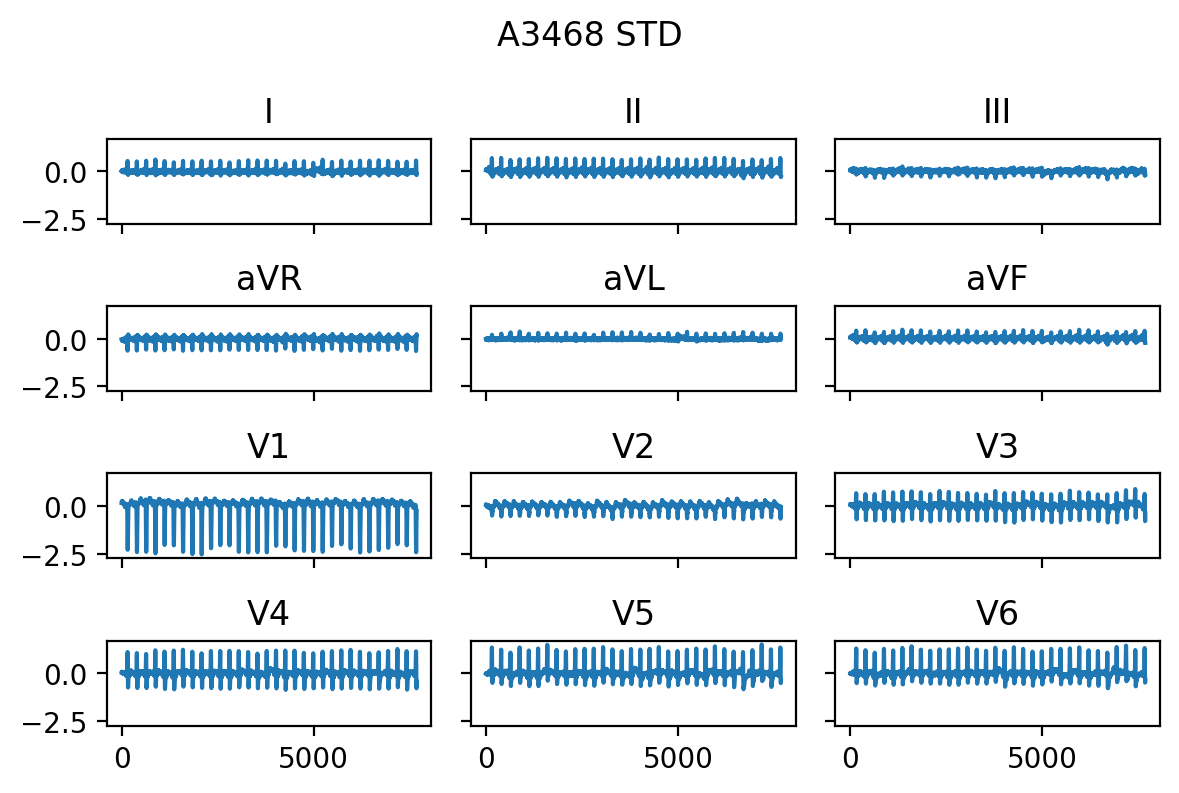

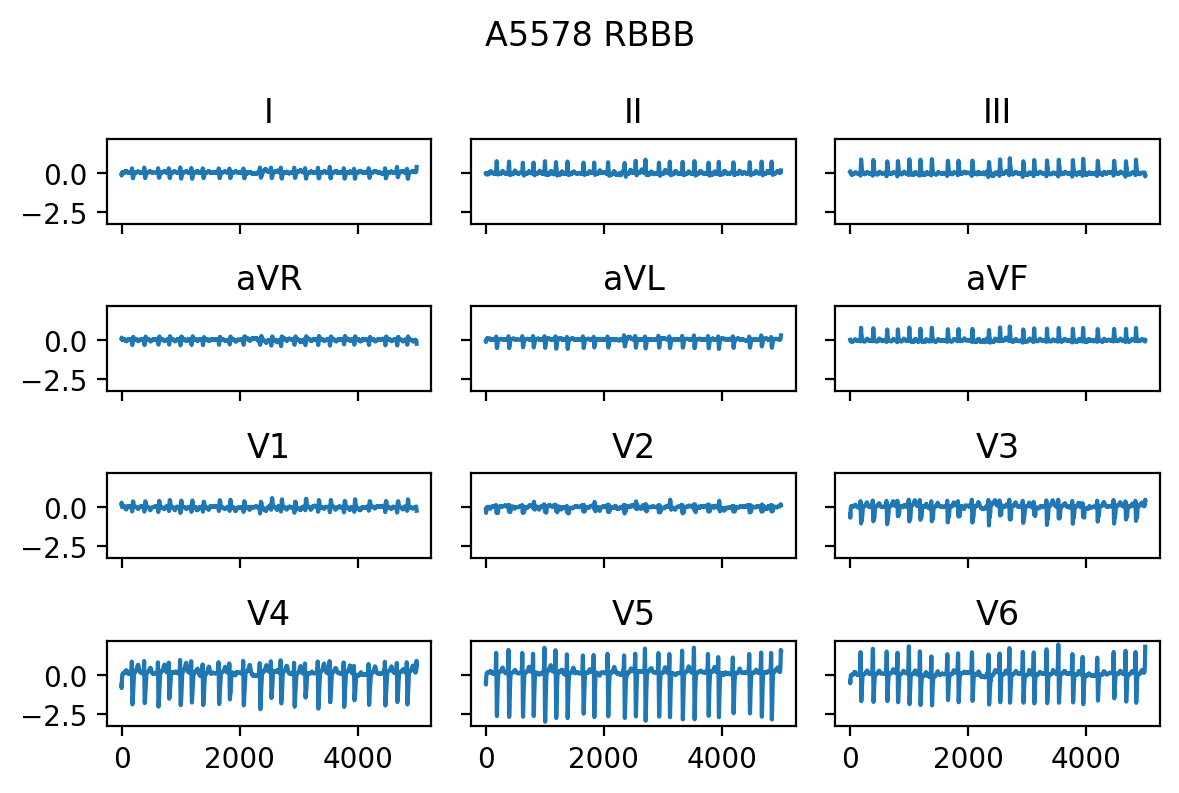

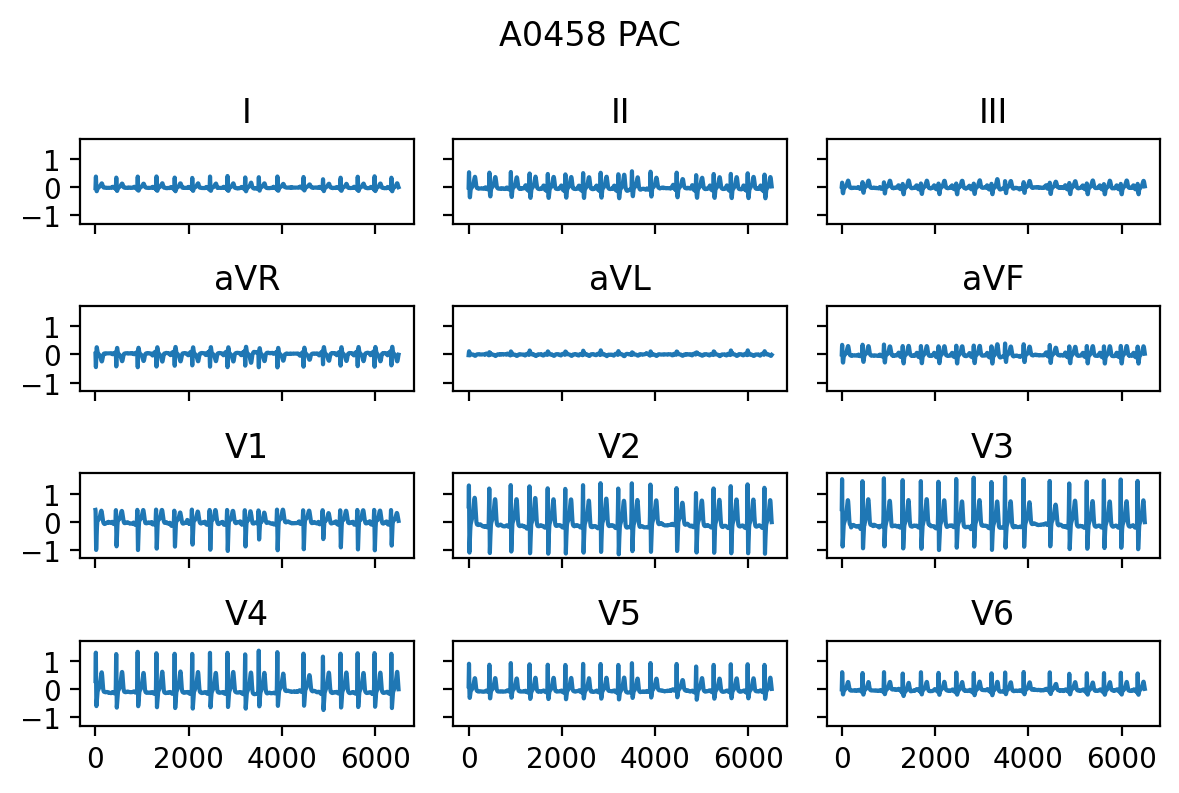

In [10]:
for i in list_file[:3]:
    site=int(np.argmax(dico_filename_label[i[:-4]]))
    
    mat=scipy.io.loadmat('/home/seb/Documents/Deep_learning/ECG/data/TrainingSet/'+i)
    good_mat=mat['ECG'][0][0][2]
    fig,_=plt.subplots(4,3,sharex=True, sharey=True)
    fig.suptitle(i[:-4]+' '+dico_label_name[site])
    for k in range(12):
        plt.subplot(4,3,k+1)
        plt.title(leads[k])
        plt.plot(np.arange(good_mat.shape[1]),good_mat[k])
    plt.tight_layout()
    plt.show()

# Data pre process

In [11]:
list_to_stratify=[dico_label_name[int(np.argmax(dico_filename_label[i[:-4]]))] for i in list_file ]

In [12]:
from sklearn.model_selection import train_test_split
list_files=[v[:-4] for v in list_file]
X_train_val,X_test,y_train_val,y_test,list_strat_train_val,list_strat_test=train_test_split(list_files,[dico_label[s] for s in list_files],list_to_stratify, stratify=list_to_stratify,random_state=0, test_size=0.1)
X_train,X_val,y_train,y_val=train_test_split(X_train_val,y_train_val,stratify=list_strat_train_val, random_state=0, test_size=0.1)

I'll keep the last 1500 points of the recording to work with

In [13]:
off=1500*1

Of course standard scaling is made on train set by pulling all the data point related to a particular lead.

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in X_train:
    mat=scipy.io.loadmat('/home/seb/Documents/Deep_learning/ECG/data/TrainingSet/'+i)
    #print(np.array([mat['ECG'][0][0][2].T[-k] for k in range(off)]).shape)
    
    scaler.partial_fit(np.array([mat['ECG'][0][0][2].T[-k] for k in range(min(off,mat['ECG'][0][0][2].shape[1]))]))

In [15]:
import pickle

pickle.dump(scaler, open('scaler_big_train_1times', 'wb'))

I had to change the way I usually work with dataloader because of SHAP, hence the # part of the code

In [16]:
from torch.utils.data import Dataset

def scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1, X.shape[1]))
    myNoise = np.matmul(np.ones((X.shape[0], 1)), scalingFactor)
    return X * myNoise


def shift(sig, interval=20):
    for col in range(sig.shape[1]):
        offset = np.random.choice(range(-interval, interval))
        sig[:, col] += offset / 1000 
    return sig


def transform(sig, train=False):
    if train:
        if np.random.randn() > 0.5: sig = scaling(sig)
        if np.random.randn() > 0.5: sig = shift(sig)
    return sig


class ECG_12_leads_GRU_dataset(Dataset):
    def __init__(self,offset, phase ,ECGs_names):#,classes):
        self.ECGs_names=ECGs_names
        #self.classes=classes
        self.phase = phase
        self.offset = offset
        
        
    def __len__(self):
        return len(self.ECGs_names)
    
    def __getitem__(self, item):
        ECGs_name=self.ECGs_names[item]
        
        ECG_=scipy.io.loadmat('/home/seb/Documents/Deep_learning/ECG/data/TrainingSet/'+ECGs_name)['ECG'][0][0][2].T
        ECG_ =(ECG_-scaler.mean_)/scaler.scale_
        nsteps, _ = ECG_.shape
        ECG_= ECG_[-self.offset:,:]
        #classe=self.classes[item]
        ECG=np.zeros((self.offset, ECG_.shape[1]))
        ECG[-nsteps:,:]=ECG_
        ECG = transform(ECG, self.phase == 'train')
        
        #return {'ECG': torch.tensor(ECG, dtype=torch.float32),
                #'classe': classe
               #}
    
        return torch.tensor(ECG, dtype=torch.float32)#,classe

In [17]:


train_dataset = ECG_12_leads_GRU_dataset(offset=off,phase=True,ECGs_names=X_train)#,classes=y_train)

train_data_loader = torch.utils.data.DataLoader(train_dataset,batch_size=128,num_workers=16)

val_dataset = ECG_12_leads_GRU_dataset(offset=off,phase=False,ECGs_names=X_val)#,classes=y_val)

val_data_loader = torch.utils.data.DataLoader(val_dataset,batch_size=128,num_workers=16)

test_dataset = ECG_12_leads_GRU_dataset(offset=off,phase=False,ECGs_names=X_test)#,classes=y_test)

test_data_loader = torch.utils.data.DataLoader(test_dataset,batch_size=128,num_workers=16)

In [18]:
class Encoder_GRU_simple(nn.Module):
    def __init__(self, n_features=12,n_classes=9,hidden_dim=200,dro=0.5):
        super(Encoder_GRU_simple, self).__init__()
        self.n_features = n_features
        self.n_classes = n_classes
        self.hidden_dim = hidden_dim
        self.dro = dro
        self.rnn1 = nn.GRU(
          input_size=n_features,
          hidden_size=2*hidden_dim,
          num_layers=1,
          batch_first=True
        )
        
        self.rnn2 = nn.GRU(
          input_size=2*hidden_dim,
          hidden_size=hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.drop = nn.Dropout(dro)
        
        
    def forward(self, x):
        x, hidden_n = self.rnn1(x)
        x = self.drop(x)
        _, hidden_n = self.rnn2(x)
        #print(hidden_n.shape,flush=True)
        return hidden_n
    

         

In [19]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import torchmetrics 

metric_f1 = torchmetrics.F1(num_classes=9,average='weighted')

In [20]:
class Classifier_GRU_simple(pl.LightningModule):
    
    def __init__(self,n_features=12,n_classes=9,lr=5e-3,wd=1e-2,dro=0.5,batch_size=128,hidden_dim=200):
        super().__init__()
        self.save_hyperparameters()
        self.my_learning_rate=lr
        self.loss = nn.CrossEntropyLoss()
        self.f1 = torchmetrics.F1(num_classes=n_classes,average='macro')
        self.n_features = n_features
        self.n_classes = n_classes
        self.hidden_dim = hidden_dim
        self.dro = dro
        self.batch_size = batch_size
        self.wd = wd
        self.encoder = Encoder_GRU_simple(n_features=self.n_features,n_classes=self.n_classes,hidden_dim=self.hidden_dim,dro=self.dro)
        self.lin = nn.Linear(self.encoder.hidden_dim,n_classes)
        
    
    def forward(self, data, mode="train"):
       
        #x,_=data
       
        xc = self.encoder(data)
        
        xc = self.lin(xc.squeeze())
        
        
        return xc
        
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=self.my_learning_rate, weight_decay=self.wd) # High lr because of small dataset and small model
        return optimizer
        
        
    def training_step(self, batch, batch_idx):
        y=torch.LongTensor(y_train[batch_idx*self.batch_size:(batch_idx+1)*self.batch_size]).to(device)
        xc = self.forward(batch, mode="train")
        loss = self.loss(xc,y)
        f1 = self.f1(torch.argmax(torch.softmax(xc,dim=1),dim=1),y)
        self.log('train_loss', loss)
        self.log('train_f1', f1)
        
        return loss
        
        
    def validation_step(self, batch, batch_idx):
        y=torch.LongTensor(y_val[batch_idx*self.batch_size:(batch_idx+1)*self.batch_size]).to(device)
        xc = self.forward(batch, mode="val")
        loss = self.loss(xc,y)
        f1 = self.f1(torch.argmax(torch.softmax(xc,dim=1),dim=1),y)
        self.log('val_loss', loss)
        self.log('val_f1', f1)
        


In [36]:
from sklearn.utils.class_weight import compute_class_weight
def train_ECG_Classifier_GRU_simple_tune():
    pl.seed_everything(42)
    
    
    root_dir = os.path.join(CHECKPOINT_PATH, "ECG_Classifier_scaled_GRU_macro_dropout_shap")
    os.makedirs(root_dir, exist_ok=True)
    
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_f1")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=500,
                         progress_bar_refresh_rate=0,auto_lr_find='my_learning_rate')
    

    
    
    model = Classifier_GRU_simple()
    
    lr_finder = trainer.tuner.lr_find(model, train_data_loader, val_data_loader)
    fig = lr_finder.plot(suggest=True)
    model.hparams.learning_rate = lr_finder.suggestion()

In [21]:
CHECKPOINT_PATH = '/home/seb/Documents/Deep_learning/ECG/data/saved_models'
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/seb/anaconda3/envs/full_deep_env/lib/python3.9/site-packages/torch/backends/cudnn/__init__.py:73: UserWarning: PyTorch was compiled without cuDNN/MIOpen support. To use cuDNN/MIOpen, rebuild PyTorch making sure the library is visible to the build system.
  warnings.warn(

  | Name    | Type               | Params
-----------------------------------------------
0 | loss    | CrossEntropyLoss   | 0     
1 | f1      | F1                 | 0     
2 | encoder | Encoder_GRU_simple | 858 K 
3 | lin     | Linear             | 1.8 K 
-----------------------------------------------
859 K     Trainable params
0         Non-trainable params
859 K     Total params
3.439     Total estimated model params size (MB)
Global seed set to 42
/home/seb/anaconda3/envs/full_deep_env/lib/python3.9/site-packages/pytorch_lightning/train

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_f1': 0.05450013652443886, 'val_loss': 2.178435802459717}
--------------------------------------------------------------------------------


Finding best initial lr:  88%|████████▊ | 88/100 [00:52<00:06,  1.76it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_f1': 0.04876553267240524, 'val_loss': 4.369797229766846}
--------------------------------------------------------------------------------


Finding best initial lr: 100%|██████████| 100/100 [01:02<00:00,  1.72it/s]Restoring states from the checkpoint file at /home/seb/Documents/Deep_learning/ECG/data/saved_models/ECG_Classifier_scaled_GRU_macro_dropout_shap/lr_find_temp_model.ckpt
Restored all states from the checkpoint file at /home/seb/Documents/Deep_learning/ECG/data/saved_models/ECG_Classifier_scaled_GRU_macro_dropout_shap/lr_find_temp_model.ckpt


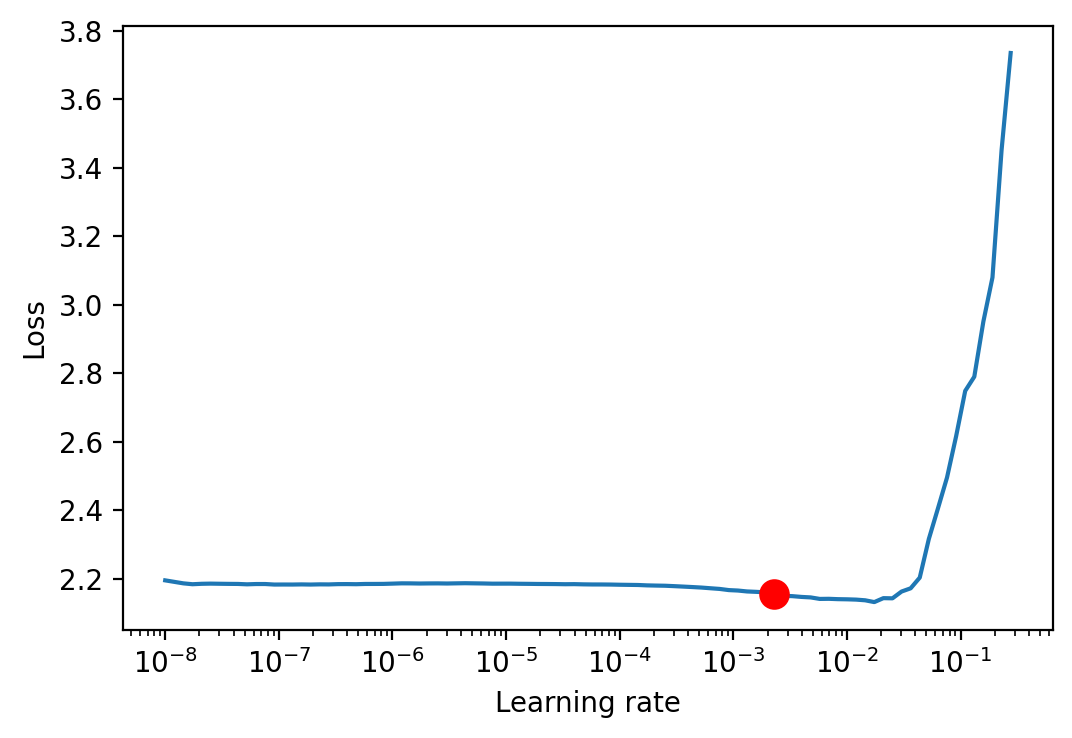

In [38]:
import torch.optim as optim
train_ECG_Classifier_GRU_simple_tune()

In [39]:
def train_ECG_Classifier_GRU_simple():
    pl.seed_everything(42)
    #w = compute_class_weight('balanced', np.unique([np.argmax(y) for y in y_train]), np.array([np.argmax(y) for y in y_train]))
    
    
    root_dir = os.path.join(CHECKPOINT_PATH, "ECG_Classifier_scaled_GRU_macro_dropout_shap")
    os.makedirs(root_dir, exist_ok=True)
    
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_f1")],
                         gpus=1 if str(device).startswith("cuda") else 0,
                         max_epochs=500,
                         progress_bar_refresh_rate=1000)
    

    
    
    model = Classifier_GRU_simple()
    
    trainer.fit(model, train_data_loader, val_data_loader)
    return model

In [40]:
trained_model=train_ECG_Classifier_GRU_simple()

Global seed set to 42
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type               | Params
-----------------------------------------------
0 | loss    | CrossEntropyLoss   | 0     
1 | f1      | F1                 | 0     
2 | encoder | Encoder_GRU_simple | 858 K 
3 | lin     | Linear             | 1.8 K 
-----------------------------------------------
859 K     Trainable params
0         Non-trainable params
859 K     Total params
3.439     Total estimated model params size (MB)


Global seed set to 42


Epoch 0: 100%|██████████| 49/49 [00:26<00:00,  1.89it/s]   
Validating: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 49/49 [00:26<00:00,  1.91it/s, loss=1.94, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 49/49 [00:26<00:00,  1.90it/s, loss=1.59, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 49/49 [00:25<00:00,  1.93it/s, loss=1.41, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 49/49 [00:25<00:00,  1.93it/s, loss=1.27, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 49/49 [00:26<00:00,  1.92it/s, loss=1.17, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 6: 100%|██████████| 49/49 [00:25<00:00,  1.93it/s, loss=1.65, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 7: 100%|██████████| 49/49 [00:25<00:00,  1.93it/s, loss=1.27, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 8: 100%|██████████| 49/49 [00:25<00:00,  1.94it/s, loss=1.28, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 49/

Finding best initial lr: 100%|██████████| 100/100 [12:51<00:00,  7.71s/it]


Epoch 24: 100%|██████████| 49/49 [01:46<00:00,  2.13s/it, loss=0.579, v_num=0] 
Validating: 0it [00:00, ?it/s]
Epoch 25: 100%|██████████| 49/49 [00:27<00:00,  1.82it/s, loss=0.57, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 26: 100%|██████████| 49/49 [00:27<00:00,  1.84it/s, loss=0.587, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 27: 100%|██████████| 49/49 [00:26<00:00,  1.87it/s, loss=0.574, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 28: 100%|██████████| 49/49 [00:27<00:00,  1.81it/s, loss=0.584, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 29: 100%|██████████| 49/49 [00:26<00:00,  1.89it/s, loss=0.549, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 30: 100%|██████████| 49/49 [00:26<00:00,  1.88it/s, loss=0.539, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 31: 100%|██████████| 49/49 [00:27<00:00,  1.85it/s, loss=0.562, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 32: 100%|██████████| 49/49 [00:26<00:00,  1.86it/s, loss=0.538, v_num=0]  
Validating: 0it [00:00, ?

Validating: 0it [00:00, ?it/s]
Epoch 91: 100%|██████████| 49/49 [00:25<00:00,  1.97it/s, loss=nan, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 92: 100%|██████████| 49/49 [00:25<00:00,  1.95it/s, loss=nan, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 93: 100%|██████████| 49/49 [00:26<00:00,  1.91it/s, loss=nan, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 94: 100%|██████████| 49/49 [00:25<00:00,  1.94it/s, loss=nan, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 95: 100%|██████████| 49/49 [00:25<00:00,  1.96it/s, loss=nan, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 96: 100%|██████████| 49/49 [00:25<00:00,  1.94it/s, loss=nan, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 97: 100%|██████████| 49/49 [00:25<00:00,  1.96it/s, loss=nan, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 98: 100%|██████████| 49/49 [00:25<00:00,  1.95it/s, loss=nan, v_num=0]  
Validating: 0it [00:00, ?it/s]
Epoch 99: 100%|██████████| 49/49 [00:25<00:00,  1.96it/s, loss=nan, v_num=0]  
Validating

/home/seb/anaconda3/envs/full_deep_env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# Results

In [22]:

trained_model_ = Classifier_GRU_simple.load_from_checkpoint('/home/seb/Documents/Deep_learning/ECG/data/saved_models/ECG_Classifier_scaled_GRU_macro_dropout_shap/lightning_logs/version_0/checkpoints/epoch=16-step=747.ckpt')

In [24]:
list_preds=[]

with torch.no_grad():
    trained_model_.eval()
    for data in test_data_loader:
        
        xc = trained_model_.encoder(data)
        xc = trained_model_.lin(xc.squeeze())
        list_preds+=torch.argmax(torch.softmax(xc,dim=1),dim=1).detach().to('cpu').tolist()
        

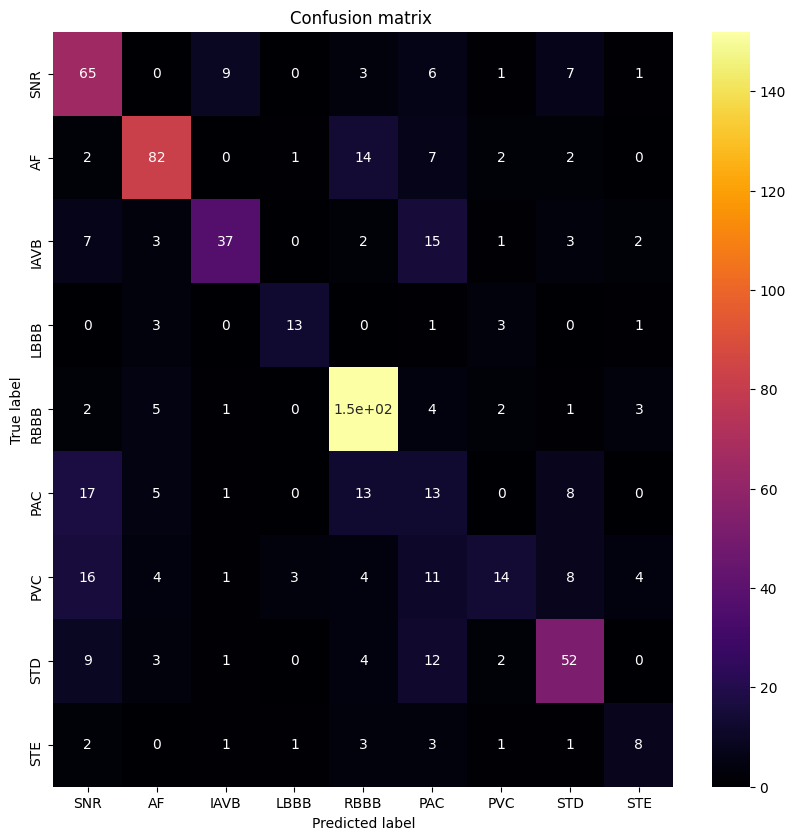

In [25]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
confusion_mc_c = confusion_matrix(y_test, list_preds)
df_cm_c = pd.DataFrame(confusion_mc_c,
                       index=['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE'],
                             columns=['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE'])

plt.figure(figsize=(10,10))
sns.heatmap(df_cm_c, annot=True, annot_kws={"size": 10},cmap='inferno')
plt.title('Confusion matrix ')
plt.ylabel('True label')
plt.xlabel('Predicted label')

plt.show()
plt.close()

In [26]:
f1_score(y_test,list_preds,average='macro')

0.5596571119580217

In [27]:
f1_score(y_test,list_preds,average='weighted')

0.6260605833551948

# SHAP values

In [28]:
import shap
batch = next(iter(train_data_loader))

explainer = shap.GradientExplainer(trained_model_,batch[:120])
shap_values = explainer.shap_values(batch[120:128])


In [29]:
good_shap_val=torch.FloatTensor(shap_values).permute(0,1,3,2)

In [30]:
with torch.no_grad():
    trained_model_.eval()
    
        
    xc = trained_model_(batch[120:128])
    y_preds_to_test=torch.argmax(torch.softmax(xc,dim=1),dim=1).detach().to('cpu').tolist()

In [31]:
y_preds_to_test

[4, 4, 0, 4, 8, 0, 7, 8]

In [32]:
y_train[120:128]

[4, 4, 0, 4, 8, 0, 7, 8]

In [33]:
def plotting_individuals_shap(looked_at,shap,dat,preds,true):
    classes_name=['SNR', 'AF', 'IAVB', 'LBBB', 'RBBB', 'PAC', 'PVC', 'STD', 'STE']
    
    for i in range(good_shap_val.shape[0]):
        threshold = 0.001

        fig,ax=plt.subplots(4,3,sharex=True, sharey=True)
        
        fig.suptitle('classe checked : {}\ntrue class: {}\npredicted class: {}'.format(classes_name[i],classes_name[true[looked_at]],classes_name[preds[looked_at]]),fontsize=5)
        for k in range(12):
            sv_upper = np.ma.masked_where(abs(shap[i][looked_at][k]) >= threshold, dat.permute(0,2,1)[looked_at][k])
            sv_lower = np.ma.masked_where(abs(shap[i][looked_at][k]) < threshold, dat.permute(0,2,1)[looked_at][k])
            sv_lower_shap = np.ma.masked_where(abs(shap[i][looked_at][k]) < threshold, shap[i][looked_at][k])
            plt.subplot(4,3,k+1)
            plt.title(leads[k],fontsize=4)
            yaya = np.arange(shap[i][looked_at].shape[1])
            
            plt.plot(yaya, sv_upper,linewidth=1,alpha=1,c='w')
            im=plt.scatter(yaya, sv_lower,s=2,c=[np.log2(abs(t))*np.sign(t) if t!='masked' else None for t in list(sv_lower_shap)],cmap='coolwarm',zorder=20)
            
            
            plt.xticks([])
            plt.yticks([])
            ax[int(k/3),k%3].set_facecolor('grey')
        cbar_ax = fig.add_axes([0.15, -0.01, 0.7, 0.05])
        
        
        plt.tight_layout()
        fig.colorbar(im, cax=cbar_ax,label='sign(SHAP)*log2(SHAP)',orientation='horizontal')
        plt.show()

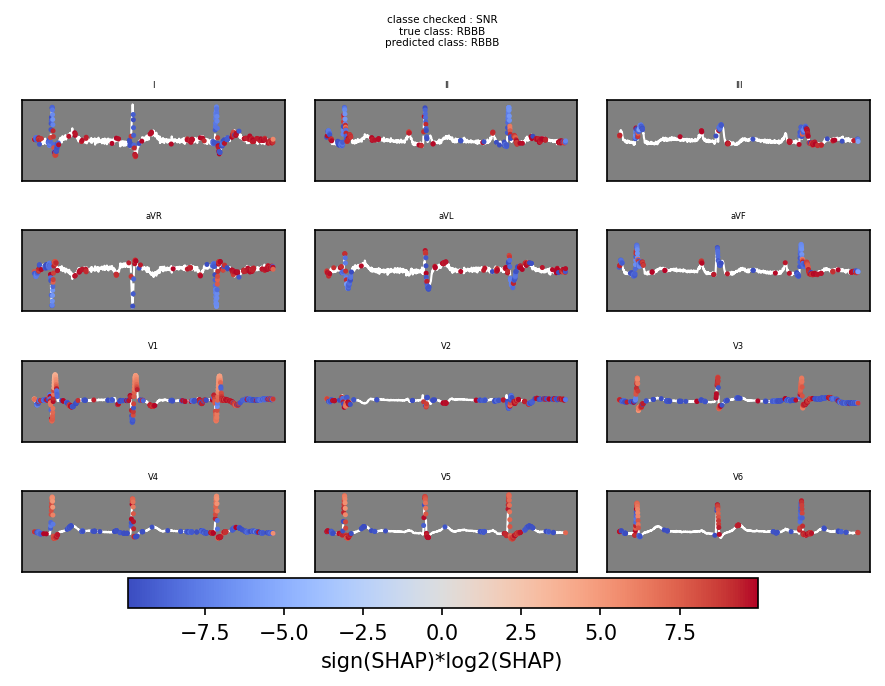

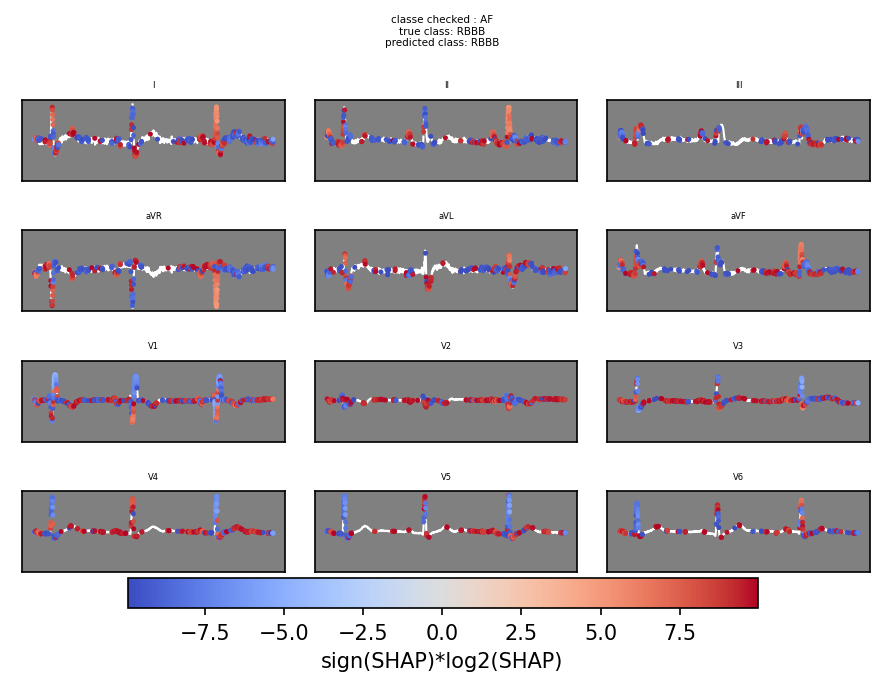

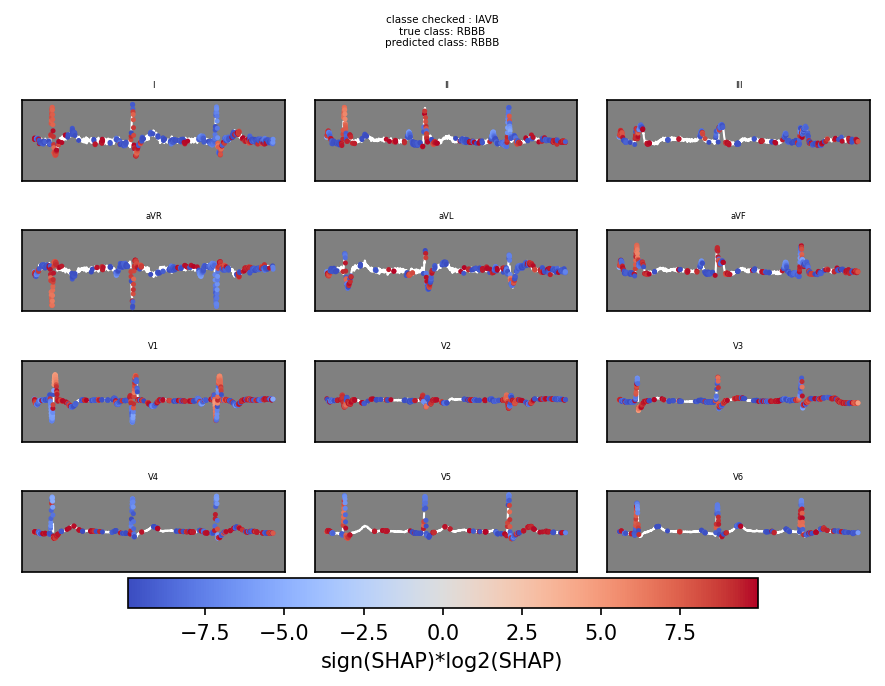

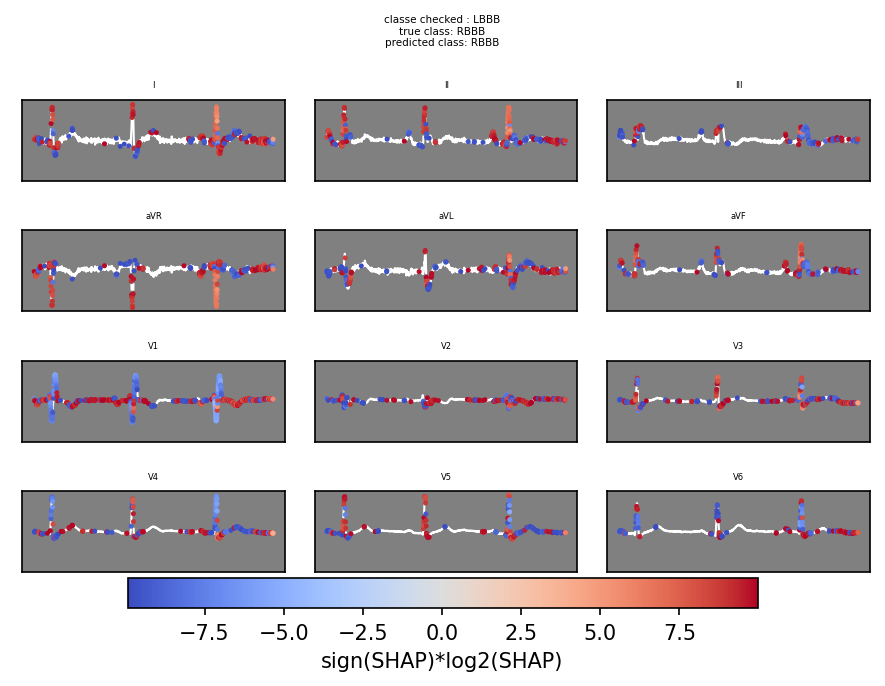

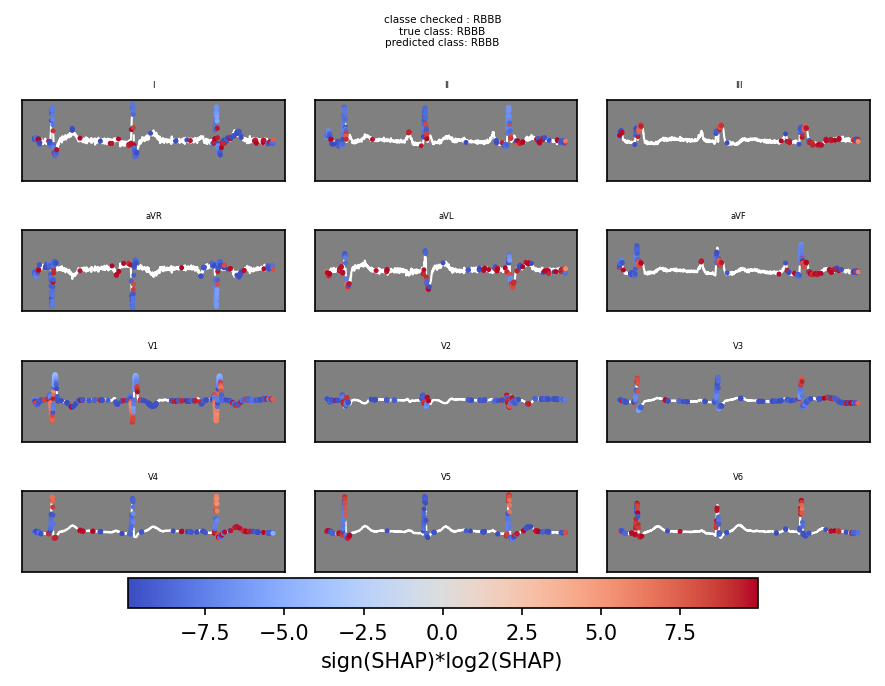

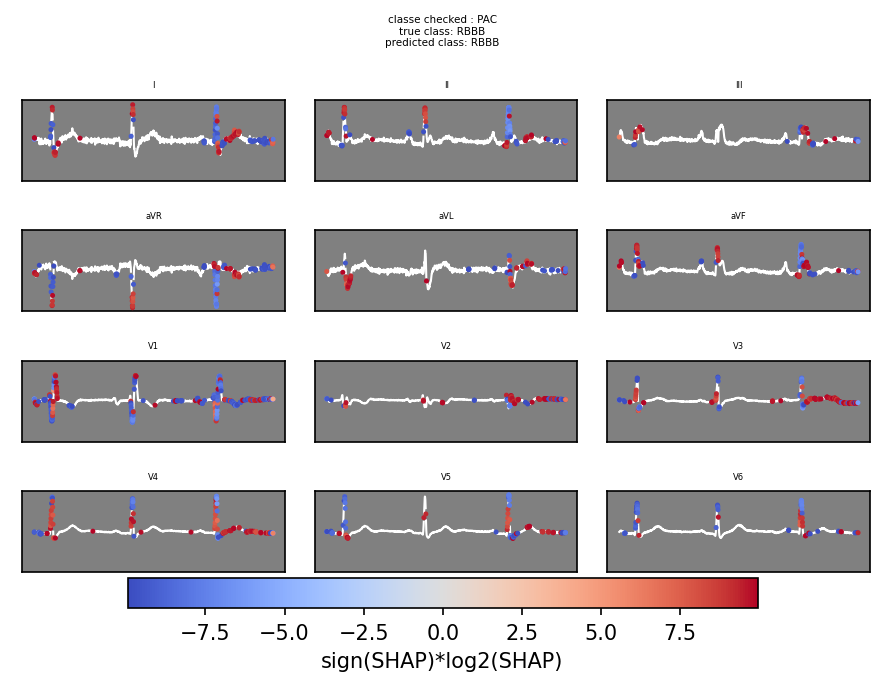

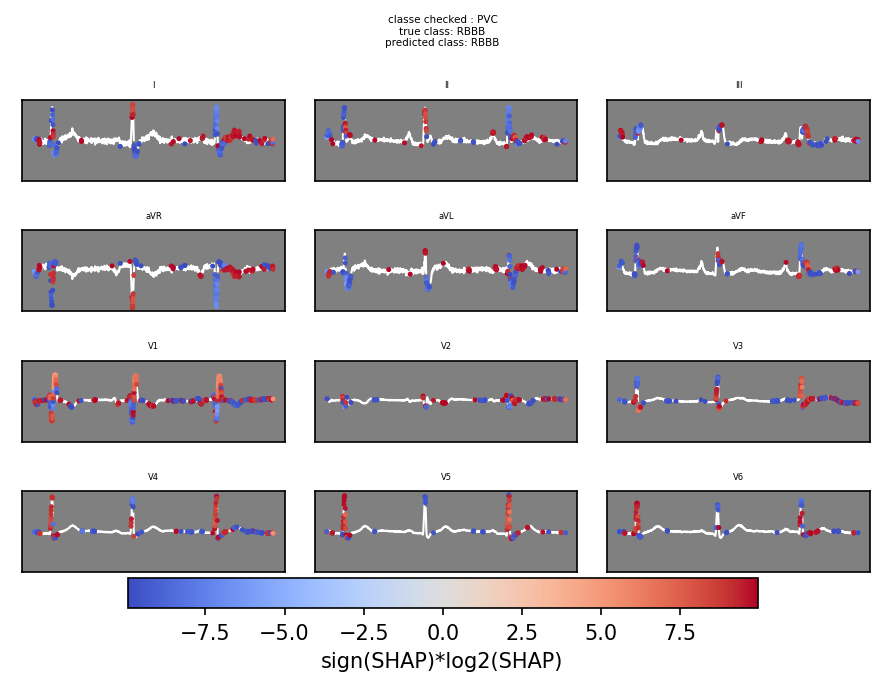

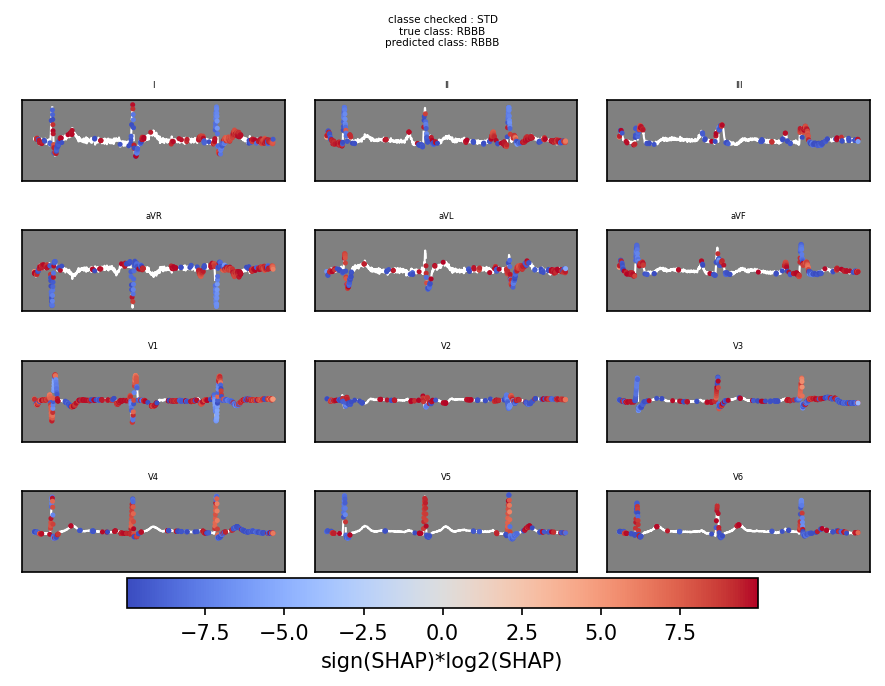

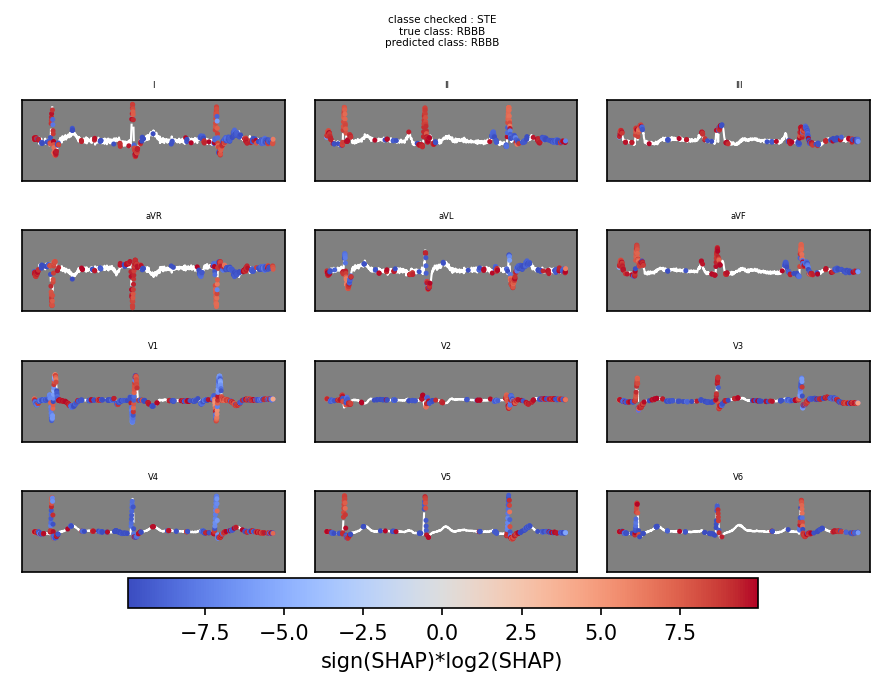

In [42]:
plotting_individuals_shap(0,good_shap_val,batch[120:128],y_preds_to_test,y_train[120:128])

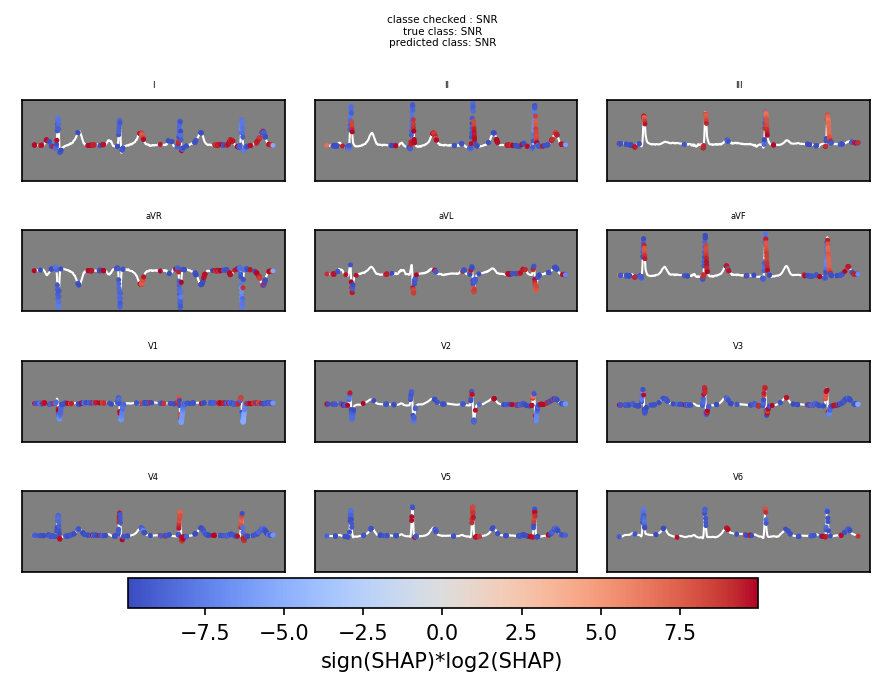

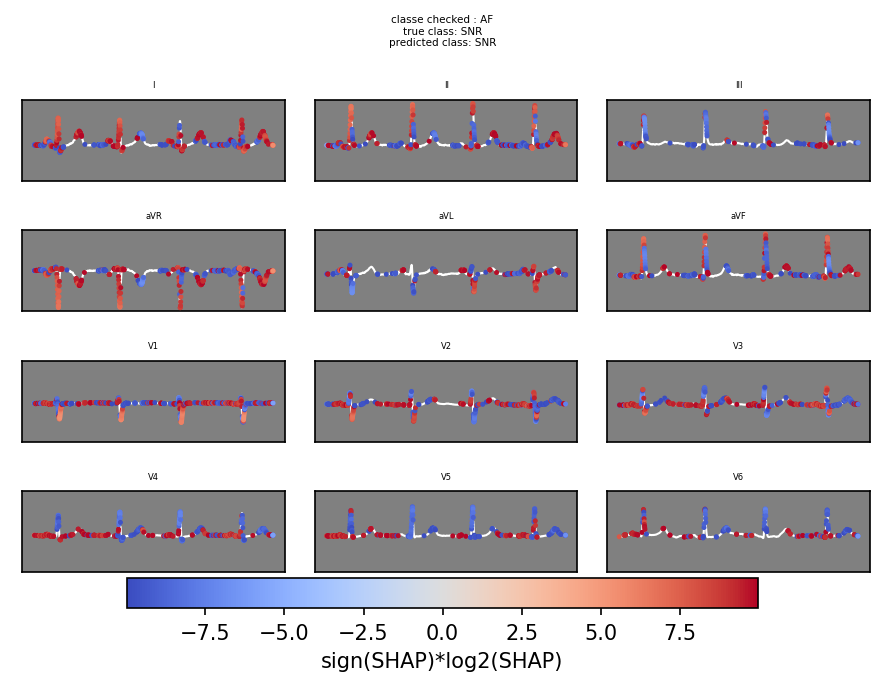

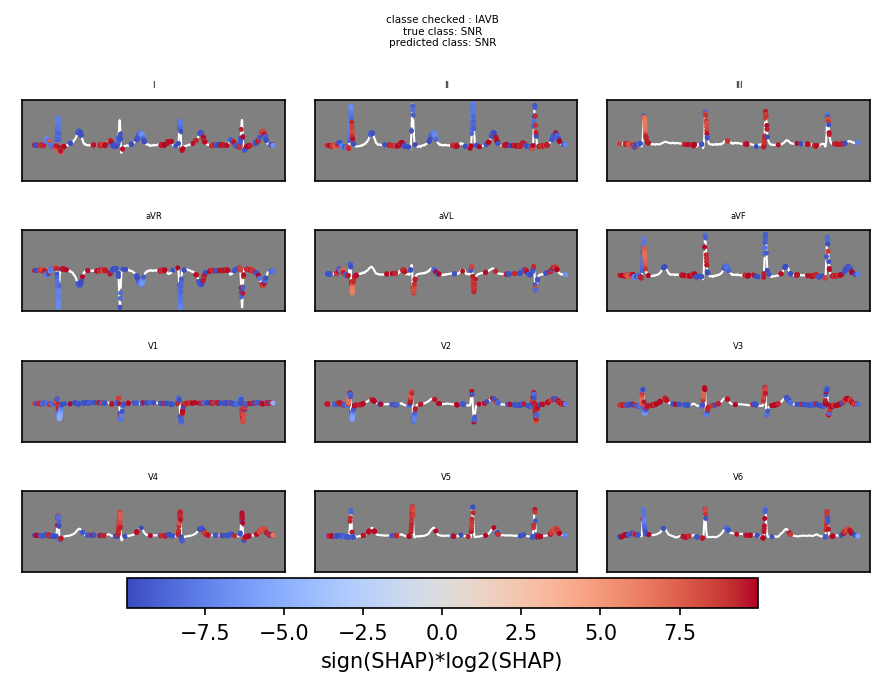

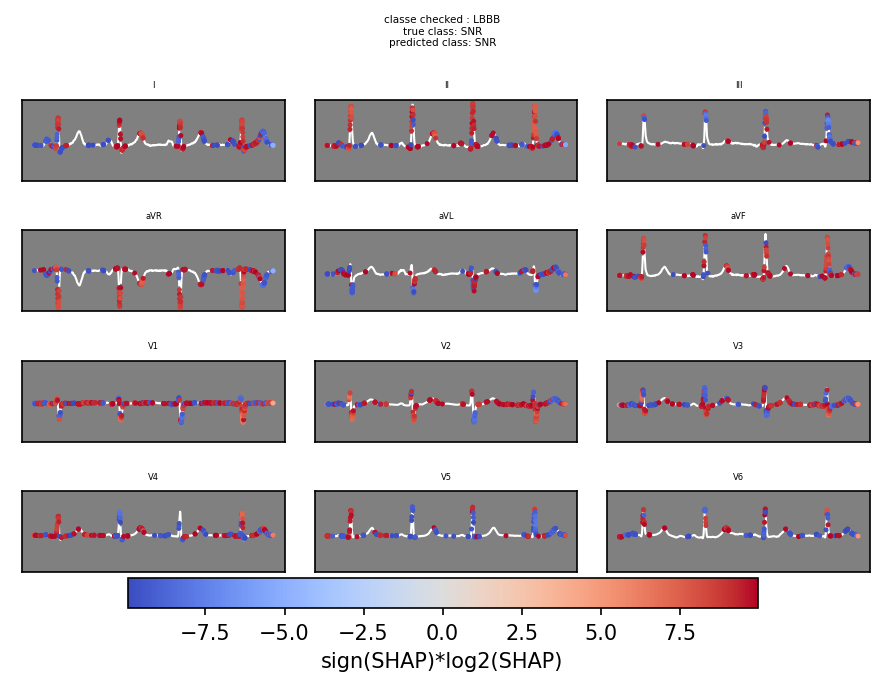

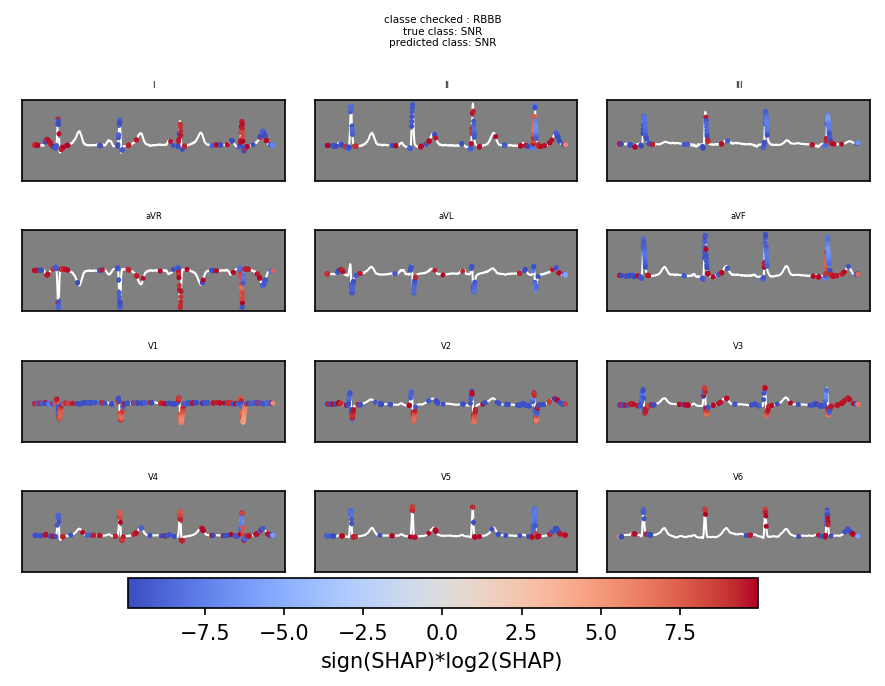

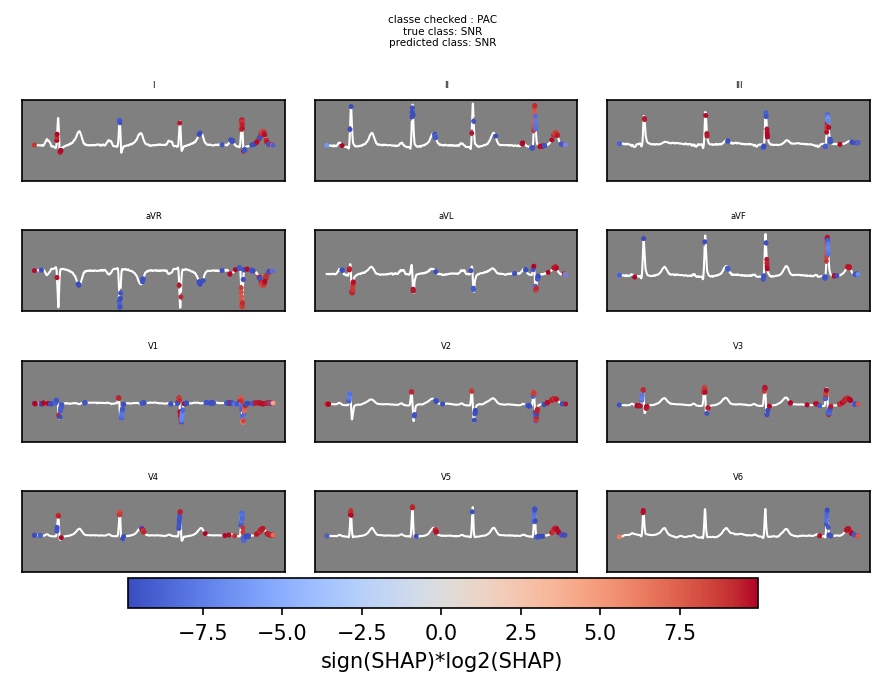

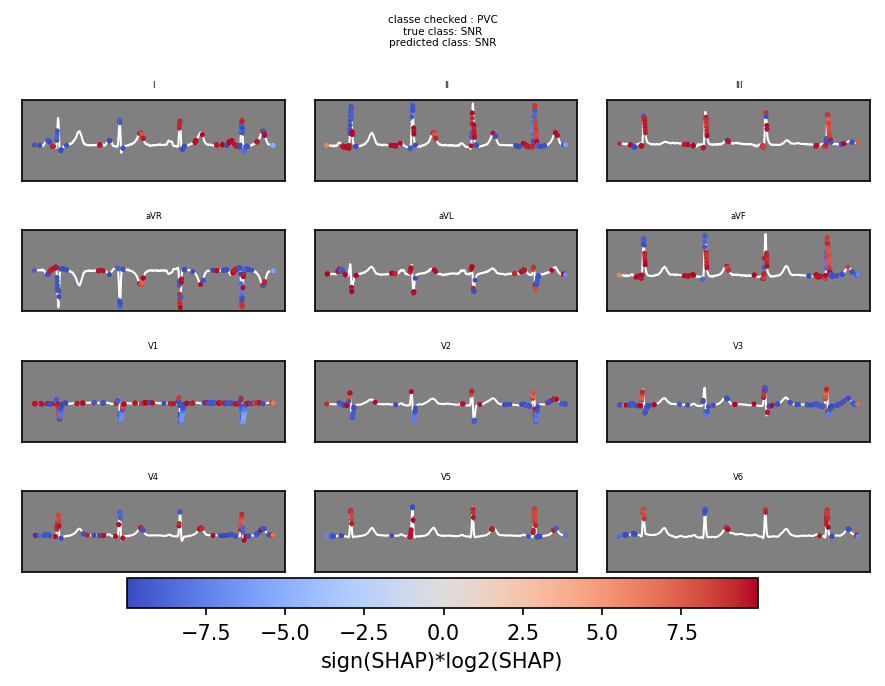

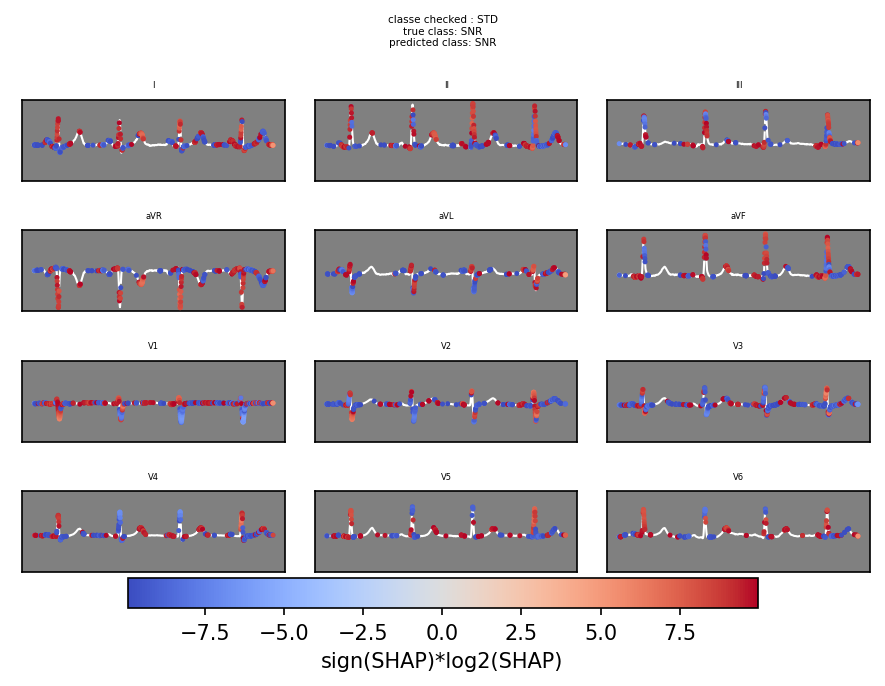

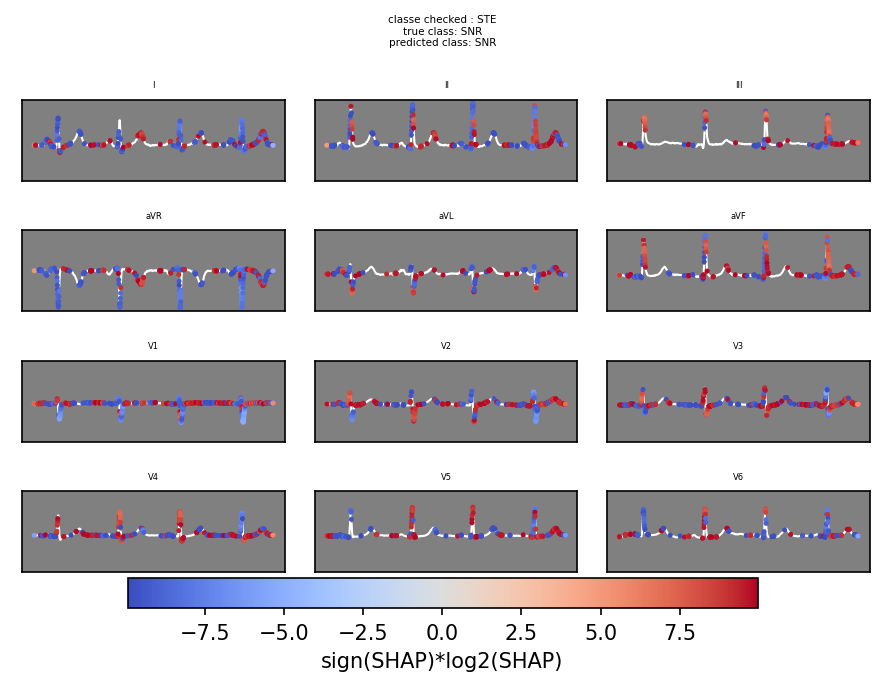

In [43]:
plotting_individuals_shap(2,good_shap_val,batch[120:128],y_preds_to_test,y_train[120:128])